# Using dask to export $\hat{s}$ from MCMC HDF5 batches and into separate HDF5 file(s)

# Libraries

In [10]:
import sys, os, glob
sys.path.insert(0, '/freya/ptmp/mpa/minh/python_script')
from pathlib import Path

import h5py as h5
import numpy as np
import dask
from dask import delayed
from dask.distributed import Client, progress
from dask_jobqueue import SLURMCluster
import dask.array as da

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import (FixedLocator, MultipleLocator, ScalarFormatter, FixedFormatter, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib.colors import ListedColormap
from matplotlib import animation
plt.set_cmap('RdBu_r')
plt.rcParams.update({
    "text.usetex": False,
    "font.sans-serif": "Fira Sans",
})
alpha=1.

dir_prefix_input='/freya/ptmp/mpa/akostic/eftcode_sampling/'
dir_prefix_output='/freya/ptmp/mpa/minh/eftcode_run/'
# assuming input and output share a common directory tree structure
common_path='paperChains/2lpt_tests/higherbias_nonzero_zero_blapl/free_phases/mockseed_111321/'
dir_path=dir_prefix_input+common_path

<Figure size 800x600 with 0 Axes>

# Get list of chain batches

In [2]:
filename_prefix='Lambda_0.1_NGeul_192_'
p=Path(dir_path)
sorted_filenames=sorted(p.glob(filename_prefix+'[0-9]*.h5'), 
                       key=lambda path: int(path.stem.rsplit("_", 1)[1]))
sorted_filenames;

# Get $\hat{s}$ chains

## Utility functions

In [3]:
def get_min_sample_in_batch(batch_path,keyword='sample_range'):
    with h5.File(batch_path) as fhandle:
        min_sample=fhandle['sample_range'][()]
    return min_sample

def get_sample_range_in_batch(batch_path,keyword='HMCinfo_'):
    with h5.File(batch_path) as fhandle:
        batch_keys=list(fhandle.keys())
    sample_id = []
    for key in batch_keys:
        if keyword in key:
            sample_id.append(key.replace(keyword,''))
    sample_id = np.asarray(sample_id,dtype=int)
    return np.array([sample_id.min(), sample_id.max()])

def get_deltad_hartley(batch):
    with h5.File(batch) as fhandle:
        deltad=fhandle['data'][()]
    deltad[0,0,0]=0.
    return deltad

def get_shat_init_hartley(batch):
    with h5.File(batch) as fhandle:
        shat_init=fhandle['shat_init'][()]
    shat_init[0,0,0]=0.
    return shat_init

def get_shat_true_hartley(batch):
    with h5.File(batch,'r') as fhandle:
        shat_true=fhandle['shat_true'][()]
    shat_true[0,0,0]=0.
    return shat_true

def get_shat_hartley_batch(batch_path,sample_range,step=1):
    shat_samples=[]
    with h5.File(batch_path,'r') as fhandle:
        for s in range(sample_range[0],sample_range[1],1):
            shat_sample=fhandle['shat_'+str(s)][()]
            shat_sample[0,0,0]=0.
            shat_samples.append(shat_sample)
    shat_batch = np.stack(shat_samples,axis=0)
    return shat_batch

def h2f(h1,h2):
    return 0.5*((h1+h2) + 1j*(h2-h1))

def hartley2fourier(hartley_arr):
    NG=hartley_arr.shape[-1] 
    res=np.empty_like(hartley_arr,dtype=np.cdouble)
    v = h2f(hartley_arr[...,0,0,0],hartley_arr[...,0,0,0])
    res[...,0,0,0] = v
    v = h2f(hartley_arr[...,1:,0,0],hartley_arr[...,::-1,:,:][...,:-1,0,0])
    res[...,1:,0,0] = v
    res[...,::-1,:,:][...,:-1,0,0] = np.conj(v)
    v = h2f(hartley_arr[...,0,1:,0],hartley_arr[...,:,::-1,:][...,0,:-1,0])
    res[...,0,1:,0] = v
    res[...,:,::-1,:][...,0,:-1,0] = np.conj(v)
    v = h2f(hartley_arr[...,0,0,1:],hartley_arr[...,:,:,::-1][...,0,0,:-1])
    res[...,0,0,1:] = v
    res[...,:,:,::-1][...,0,0,:-1] = np.conj(v)
    v = h2f(hartley_arr[...,1:,1:,0],hartley_arr[...,::-1,::-1,:][...,:-1,:-1,0])
    res[...,1:,1:,0] = v
    res[...,::-1,::-1,:][...,:-1,:-1,0] = np.conj(v)
    v = h2f(hartley_arr[...,1:,0,1:],hartley_arr[...,::-1,:,::-1][...,:-1,0,:-1])
    res[...,1:,0,1:] = v
    res[...,::-1,:,::-1][...,:-1,0,:-1] = np.conj(v)
    v = h2f(hartley_arr[...,0,1:,1:],hartley_arr[...,:,::-1,::-1][...,0,:-1,:-1])
    res[...,0,1:,1:] = v
    res[...,:,::-1,::-1][...,0,:-1,:-1] = np.conj(v)
    v = h2f(hartley_arr[...,1:,1:,1:],hartley_arr[...,::-1,::-1,::-1][...,:-1,:-1,:-1])
    res[...,1:,1:,1:] = v
    res[...,::-1,::-1,::-1][...,:-1,:-1,:-1] = np.conj(v)         
    return res

def prepare_kgrid(Lbox,Ngrid,nr_k_bins=20,k_min=None,k_max=None):
    box_size  = Lbox
    nr_cells   = Ngrid
    if (k_min is None):
        k_min      = (2.*np.pi) / box_size
    if (k_max is None):
        k_max      = (np.pi*nr_cells) / box_size
    k_vector  = (2.*np.pi) * np.fft.fftfreq(nr_cells, d=box_size/nr_cells)
    k_grid    = np.sqrt(k_vector[:,None,None]**2 + k_vector[None,:,None]**2 \
                    + k_vector[None,None,:]**2)
    
    k_bins    = np.histogram(k_grid, bins=nr_k_bins, range=[k_min, k_max])
    return k_grid, k_bins, k_min, k_max

def sharpk_filter(x,k_grid,Lambda):
    return np.where(k_grid<=Lambda,x,0.)

## Setup dask client

In [4]:
cluster = SLURMCluster(cores=40,memory='192 GB',
                       walltime='03:00:00',local_directory='/freya/ptmp/mpa/minh/tmp/dask/',
                      job_extra=['-o /freya/ptmp/mpa/minh/std/LEFTFIELD/dask/LOG_worker_%j.o',
                                 '-e /freya/ptmp/mpa/minh/std/LEFTFIELD/dask/LOG_worker_%j.o'],
                       interface='ib0',
                      scheduler_options={'interface':'ib0','dashboard_address':':8887'})

/u/minh/conda-envs/py39forge/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


In [5]:
nr_nodes=6
cluster.scale(jobs=nr_nodes)
client = Client(cluster)
client.get_versions(check=True)
client

/u/minh/conda-envs/py39forge/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: proxy/8887/status,
Dashboard: proxy/8887/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.183.26:38567,Workers: 0
Dashboard: proxy/8887/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Get sample ranges for all MCMC batches

In [6]:
sample_ranges_futures=client.map(get_sample_range_in_batch,sorted_filenames)

In [7]:
sample_ranges=np.asarray(client.gather(sample_ranges_futures))
sample_ranges

array([[    0,  5057],
       [ 5056, 10207],
       [10207, 15331],
       [15331, 20502],
       [20503, 25699],
       [25699, 30877]])

## Get $\hat{s}_{\mathrm{true}}$ and visualize a slice through its $z$-axis

### I. Load $\hat{s}_{\mathrm{true}}$

In [8]:
with h5.File(sorted_filenames[0],'r') as fhandle:
    shat_true=da.from_array(fhandle['shat_true'][()])
    shat_true[0,0,0]=0.
shat_true

dask.array<setitem, shape=(64, 64, 64), dtype=float64, chunksize=(64, 64, 64), chunktype=numpy.ndarray>

### Filter $\hat{s}_{\mathrm{true}}$

In [19]:
Lbox=2000.
N_grid=shat_true.shape[-1]
nr_k_bins=100
k_modes, k_bins, k_min, k_max = prepare_kgrid(Lbox,N_grid,nr_k_bins,k_min=0.,k_max=0.14)
Lambda0=0.1

shat_true_hartley_filtered=sharpk_filter(shat_true,k_modes,Lambda=Lambda0)
shat_true_fourier_filtered=hartley2fourier(shat_true_hartley_filtered)
shat_true_real_filtered=np.fft.ifftn(shat_true_fourier_filtered).real

### Plot a 2D slice of $\hat{s}_{\mathrm{true}}$ through the $z$-axis

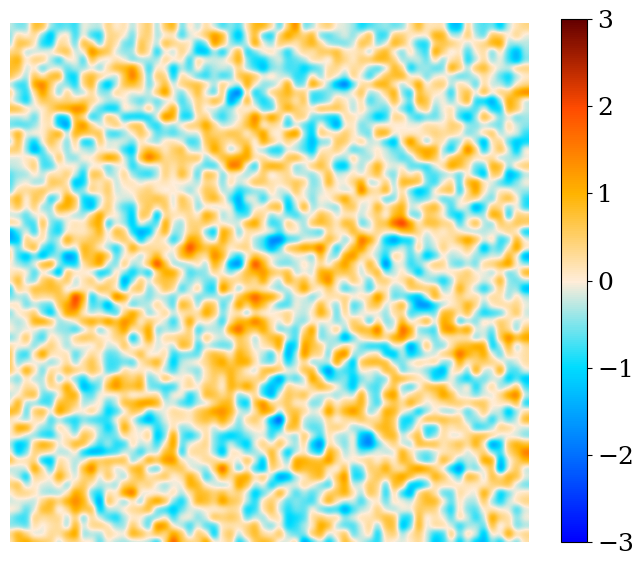

In [15]:
slice_id=40

fig = plt.figure()
ax = plt.axes()
ax.set_frame_on(False)
fig.patch.set_alpha(0.)
# set axis limit
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_ylim(0, N_grid)
ax.set_xlim(0, N_grid)
im=ax.imshow(shat_true_real_filtered[...,slice_id],interpolation='gaussian',cmap=Planck_cmap,vmin=-3,vmax=3)
cbar = plt.colorbar(im,ax=ax,fraction=0.046, pad=0.04)
cbar.formatter.set_powerlimits((0, 0))
plt.tight_layout()
shat_true_slice_path=r"/freya/ptmp/mpa/minh/shat_true_real_filtered_slice40_Planck.png"
fig.savefig(shat_true_slice_path,transparent=True)

## Get $\hat{s}$ from all MCMC batches

### I. Asemble a dask array of (lazy) dask arrays that contain the $\hat{s}$ field

In [16]:
shat_hartley_batches=[dask.delayed(get_shat_hartley_batch)(sorted_filename,sample_range) for sorted_filename, sample_range in zip(sorted_filenames[:2],sample_ranges[:2])]
# list of (delayed) shat samples
shat_hartley_list=[da.from_delayed(shat,shape=((sample_range[1]-sample_range[0],shat_true.shape[0],shat_true.shape[1],shat_true.shape[2])),dtype=np.float64) for shat,sample_range in zip(shat_hartley_batches,sample_ranges[:2])]
# concatenate the list to form a dask array of shat samples
shat_hartley_chain=da.concatenate(shat_hartley_list,axis=0)
shat_hartley_chain=shat_hartley_chain.rechunk((90,shat_true.shape[0],shat_true.shape[1],shat_true.shape[2]))
shat_hartley_chain

dask.array<rechunk-merge, shape=(10208, 64, 64, 64), dtype=float64, chunksize=(90, 64, 64, 64), chunktype=numpy.ndarray>

### II. Construct the dask graph(s) of operations on this list

#### 1) We convert Hartley to Fourier representation

In [17]:
# Better to explicitly provide meta rather than let dask determine it (see doc)
# Fourier representation involves complex numbers, hence the dtype in meta
meta = np.array([],dtype=np.cdouble)
shat_fourier_chain = shat_hartley_chain.map_blocks(hartley2fourier,meta=meta)
shat_fourier_chain

dask.array<hartley2fourier, shape=(10208, 64, 64, 64), dtype=complex128, chunksize=(90, 64, 64, 64), chunktype=numpy.ndarray>

#### 2) We filter the $\hat{s}$ field using a sharp-k filter

In [20]:
shat_fourier_chain_filtered = shat_fourier_chain.map_blocks(sharpk_filter,k_modes,Lambda0,meta=meta)
shat_fourier_chain_filtered

dask.array<sharpk_filter, shape=(10208, 64, 64, 64), dtype=complex128, chunksize=(90, 64, 64, 64), chunktype=numpy.ndarray>

#### 3) We transform the filtered $\hat{s}(k)$ from Fourier-space to real-space $\hat{s}(x)$

In [21]:
# Only take the real part after the ifftn transform
meta = np.array([],dtype=np.float64)
shat_real_chain_filtered = (shat_fourier_chain_filtered.map_blocks(np.fft.ifftn,meta=meta,axes=(1,2,3))).real
shat_real_chain_filtered

dask.array<real, shape=(10208, 64, 64, 64), dtype=float64, chunksize=(90, 64, 64, 64), chunktype=numpy.ndarray>

### III. Actually retrieve the result(s) for a 2D slice of $\hat{s}(x)$ through the $z$-axis

In [22]:
shat_real_chain_filtered_slice=shat_real_chain_filtered[:,:,:,slice_id]
shat_real_chain_filtered_slice

dask.array<getitem, shape=(10208, 64, 64), dtype=float64, chunksize=(90, 64, 64), chunktype=numpy.ndarray>

In [23]:
shat_real_chain_filtered_slice=client.persist(shat_real_chain_filtered_slice)
shat_real_chain_filtered_slice

dask.array<getitem, shape=(10208, 64, 64), dtype=float64, chunksize=(90, 64, 64), chunktype=numpy.ndarray>

In [24]:
shat_zslice_filtered=shat_real_chain_filtered_slice.compute()
#filename=dir_prefix_output+common_path+'test_shat_real_chain_filtered_slice.npy'
#np.save(filename,shat_zslice_filtered)

## Visualize a $\hat{s}(x)$ slice and animate the whole MCMC chain of the same $\hat{s}$ slice

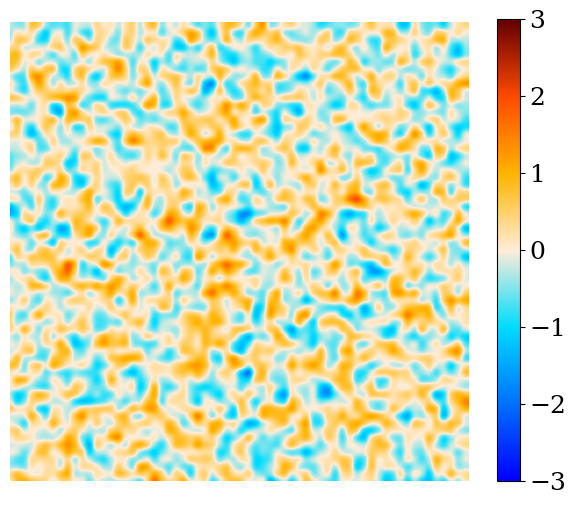

In [25]:
fig = plt.figure()
ax = plt.axes()
ax.set_frame_on(False)
fig.patch.set_alpha(0.)
# set axis limit
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_ylim(0, N_grid)
ax.set_xlim(0, N_grid)
im = ax.imshow(shat_zslice_filtered[0,...],interpolation='gaussian',alpha=alpha,cmap=Planck_cmap,vmin=-3,vmax=3)
cbar = plt.colorbar(im,ax=ax,fraction=0.046, pad=0.04)
cbar.formatter.set_powerlimits((0, 0))

In [26]:
# Create a list of artists (one for each frame)
artists = []
for slice in range(shat_zslice_filtered.shape[0]):
    # Create an artist for the current frame
    artist = ax.imshow(shat_zslice_filtered[slice,...],interpolation='gaussian',alpha=alpha,cmap=Planck_cmap,vmin=-3,vmax=3)
    artists.append([artist])

# Create the animation using the list of artists
anim = animation.ArtistAnimation(fig, artists, interval=150, blit=True, repeat=True, repeat_delay=1000)
filename=r""
save_path=dir_prefix_output+common_path+filename
writer = animation.FFMpegWriter(
     fps=30, metadata=dict(artist='Minh'), bitrate=1800)
anim.save(save_path, writer=writer, savefig_kwargs={"transparent": True})

# Display the animation
plt.show()